In [1]:
import os
from importlib.resources import files

import copy
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *

## Load Dataset

In [2]:
dim = 2
num_traj = 3  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory

train_x = np.empty((0, 4))
train_y = np.empty((0, 2))

for i in range(1, num_traj + 1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    data[idx,:2] -= data[-1,:2]
    data[-1,2:4] = np.zeros(2)
    data[-1,-2:] = np.zeros(2)
    
    # add to datset
    train_x = np.append(train_x, data[idx,:4], axis=0)
    train_y = np.append(train_y, data[idx,-2:], axis=0)

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)

## Create Model

In [4]:
model_first = FirstGeometry(Embedding(FeedForward(dim, [64]*2, 1)), 
                      torch.tensor([0.0,0.0]).to(device), 
                      SPD(dim)).to(device)
TorchHelper.load(model_first,'../outputs/Khamesh_1')

In [5]:
# torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])
# approximator = KernelMachine(dim, 1000, 1, length=0.4)

num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

# embedding = copy.deepcopy(model_first.embedding)
# TorchHelper.set_grad(embedding, False)
embedding = Embedding(approximator)

# stiffness = copy.deepcopy(model_first.stiffness)
# dissipation = copy.deepcopy(model_first.stiffness)
# dissipation.eigval = 2*dissipation.eigval
# stiffness = Spherical()
# dissipation = Spherical()
stiffness = SPD(dim)
dissipation = SPD(dim)

attractor = train_x[-1][:2].detach()

field = LinearField(attractor, Spherical(1.0, True))
field_weight = 1.0

model = SecondGeometry(embedding, attractor, stiffness, dissipation).to(device)
# TorchHelper.load(model, '../outputs/' + dataset + '_2')
model.velocity_embedding = False
TorchHelper.set_grad(model_first, False)

In [23]:
attractor

tensor([0., 0.], device='cuda:0')

## Train

In [6]:
trainer = Trainer(model, train_x, train_y)

trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
# trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

trainer.loss = torch.nn.MSELoss()
# trainer.loss = torch.nn.SmoothL1Loss()
# trainer.loss = WeighedMagnitudeDirectionLoss(magnitude_weight=0.0, direction_weight=1.0)

trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=1000)

trainer.train()
# TorchHelper.save(model, '../outputs/' + dataset + '_2')

EPOCH:  0 ITER:  0 LR:  0.01 LOSS:  0.08295900374650955
EPOCH:  1 ITER:  0 LR:  0.01 LOSS:  0.0434136688709259
EPOCH:  2 ITER:  0 LR:  0.01 LOSS:  0.020091848447918892
EPOCH:  3 ITER:  0 LR:  0.01 LOSS:  0.014492124319076538
EPOCH:  4 ITER:  0 LR:  0.01 LOSS:  0.013757232576608658
EPOCH:  5 ITER:  0 LR:  0.01 LOSS:  0.013118845410645008
EPOCH:  6 ITER:  0 LR:  0.01 LOSS:  0.012365275993943214
EPOCH:  7 ITER:  0 LR:  0.01 LOSS:  0.011721234768629074
EPOCH:  8 ITER:  0 LR:  0.01 LOSS:  0.011260205879807472
EPOCH:  9 ITER:  0 LR:  0.01 LOSS:  0.010942487046122551
EPOCH:  10 ITER:  0 LR:  0.01 LOSS:  0.010695193894207478
EPOCH:  11 ITER:  0 LR:  0.01 LOSS:  0.010460109449923038
EPOCH:  12 ITER:  0 LR:  0.01 LOSS:  0.010210229083895683
EPOCH:  13 ITER:  0 LR:  0.01 LOSS:  0.009945878759026527
EPOCH:  14 ITER:  0 LR:  0.01 LOSS:  0.009682404808700085
EPOCH:  15 ITER:  0 LR:  0.01 LOSS:  0.009438137523829937
EPOCH:  16 ITER:  0 LR:  0.01 LOSS:  0.009226289577782154
EPOCH:  17 ITER:  0 LR:  0.

EPOCH:  146 ITER:  0 LR:  0.01 LOSS:  0.006167285609990358
EPOCH:  147 ITER:  0 LR:  0.01 LOSS:  0.006147993262857199
EPOCH:  148 ITER:  0 LR:  0.01 LOSS:  0.006149185821413994
EPOCH:  149 ITER:  0 LR:  0.01 LOSS:  0.006124039646238089
EPOCH:  150 ITER:  0 LR:  0.01 LOSS:  0.006120072677731514
EPOCH:  151 ITER:  0 LR:  0.01 LOSS:  0.006101355422288179
EPOCH:  152 ITER:  0 LR:  0.01 LOSS:  0.00609435373917222
EPOCH:  153 ITER:  0 LR:  0.01 LOSS:  0.006082847714424133
EPOCH:  154 ITER:  0 LR:  0.01 LOSS:  0.006069608964025974
EPOCH:  155 ITER:  0 LR:  0.01 LOSS:  0.006061732769012451
EPOCH:  156 ITER:  0 LR:  0.01 LOSS:  0.00604392820969224
EPOCH:  157 ITER:  0 LR:  0.01 LOSS:  0.006038076244294643
EPOCH:  158 ITER:  0 LR:  0.01 LOSS:  0.006021594628691673
EPOCH:  159 ITER:  0 LR:  0.01 LOSS:  0.006015304010361433
EPOCH:  160 ITER:  0 LR:  0.01 LOSS:  0.006001533940434456
EPOCH:  161 ITER:  0 LR:  0.01 LOSS:  0.005990168079733849
EPOCH:  162 ITER:  0 LR:  0.01 LOSS:  0.005980855785310268

EPOCH:  291 ITER:  0 LR:  0.01 LOSS:  0.004577930551022291
EPOCH:  292 ITER:  0 LR:  0.01 LOSS:  0.004655028693377972
EPOCH:  293 ITER:  0 LR:  0.01 LOSS:  0.004951611626893282
EPOCH:  294 ITER:  0 LR:  0.01 LOSS:  0.005070552695542574
EPOCH:  295 ITER:  0 LR:  0.01 LOSS:  0.004519984126091003
EPOCH:  296 ITER:  0 LR:  0.01 LOSS:  0.0054247318767011166
EPOCH:  297 ITER:  0 LR:  0.01 LOSS:  0.0052736843936145306
EPOCH:  298 ITER:  0 LR:  0.01 LOSS:  0.005773128475993872
EPOCH:  299 ITER:  0 LR:  0.01 LOSS:  0.005656743887811899
EPOCH:  300 ITER:  0 LR:  0.01 LOSS:  0.005703664384782314
EPOCH:  301 ITER:  0 LR:  0.01 LOSS:  0.005656535271555185
EPOCH:  302 ITER:  0 LR:  0.01 LOSS:  0.005407046992331743
EPOCH:  303 ITER:  0 LR:  0.01 LOSS:  0.00554755050688982
EPOCH:  304 ITER:  0 LR:  0.01 LOSS:  0.005248701199889183
EPOCH:  305 ITER:  0 LR:  0.01 LOSS:  0.005373902153223753
EPOCH:  306 ITER:  0 LR:  0.01 LOSS:  0.005190275609493256
EPOCH:  307 ITER:  0 LR:  0.01 LOSS:  0.005263211671262

EPOCH:  430 ITER:  0 LR:  0.01 LOSS:  0.005299908109009266
EPOCH:  431 ITER:  0 LR:  0.01 LOSS:  0.005153014790266752
EPOCH:  432 ITER:  0 LR:  0.01 LOSS:  0.0051611945964396
EPOCH:  433 ITER:  0 LR:  0.01 LOSS:  0.005075298249721527
EPOCH:  434 ITER:  0 LR:  0.01 LOSS:  0.005071344319730997
EPOCH:  435 ITER:  0 LR:  0.01 LOSS:  0.004984637722373009
EPOCH:  436 ITER:  0 LR:  0.01 LOSS:  0.005026641301810741
EPOCH:  437 ITER:  0 LR:  0.01 LOSS:  0.004925248678773642
EPOCH:  438 ITER:  0 LR:  0.01 LOSS:  0.004946048371493816
EPOCH:  439 ITER:  0 LR:  0.01 LOSS:  0.004864182323217392
EPOCH:  440 ITER:  0 LR:  0.01 LOSS:  0.004811170510947704
EPOCH:  441 ITER:  0 LR:  0.01 LOSS:  0.004772986751049757
EPOCH:  442 ITER:  0 LR:  0.01 LOSS:  0.0046660578809678555
EPOCH:  443 ITER:  0 LR:  0.01 LOSS:  0.004647606052458286
EPOCH:  444 ITER:  0 LR:  0.01 LOSS:  0.004567042458802462
EPOCH:  445 ITER:  0 LR:  0.01 LOSS:  0.004495955538004637
EPOCH:  446 ITER:  0 LR:  0.01 LOSS:  0.00446296343579888

EPOCH:  576 ITER:  0 LR:  0.01 LOSS:  0.0007398381712846458
EPOCH:  577 ITER:  0 LR:  0.01 LOSS:  0.0007372944965027273
EPOCH:  578 ITER:  0 LR:  0.01 LOSS:  0.0007347697392106056
EPOCH:  579 ITER:  0 LR:  0.01 LOSS:  0.000732394284568727
EPOCH:  580 ITER:  0 LR:  0.01 LOSS:  0.0007299182470887899
EPOCH:  581 ITER:  0 LR:  0.01 LOSS:  0.0007275757961906493
EPOCH:  582 ITER:  0 LR:  0.01 LOSS:  0.0007252439390867949
EPOCH:  583 ITER:  0 LR:  0.01 LOSS:  0.0007229336188174784
EPOCH:  584 ITER:  0 LR:  0.01 LOSS:  0.0007206660811789334
EPOCH:  585 ITER:  0 LR:  0.01 LOSS:  0.0007184282294474542
EPOCH:  586 ITER:  0 LR:  0.01 LOSS:  0.000716222682967782
EPOCH:  587 ITER:  0 LR:  0.01 LOSS:  0.000714037858415395
EPOCH:  588 ITER:  0 LR:  0.01 LOSS:  0.0007119097281247377
EPOCH:  589 ITER:  0 LR:  0.01 LOSS:  0.0007097665220499039
EPOCH:  590 ITER:  0 LR:  0.01 LOSS:  0.0007076849578879774
EPOCH:  591 ITER:  0 LR:  0.01 LOSS:  0.0007056032191030681
EPOCH:  592 ITER:  0 LR:  0.01 LOSS:  0.000

EPOCH:  715 ITER:  0 LR:  0.01 LOSS:  0.0005421956302598119
EPOCH:  716 ITER:  0 LR:  0.01 LOSS:  0.0005413140752352774
EPOCH:  717 ITER:  0 LR:  0.01 LOSS:  0.0005404381663538516
EPOCH:  718 ITER:  0 LR:  0.01 LOSS:  0.0005395676707848907
EPOCH:  719 ITER:  0 LR:  0.01 LOSS:  0.0005387056735344231
EPOCH:  720 ITER:  0 LR:  0.01 LOSS:  0.0005378533969633281
EPOCH:  721 ITER:  0 LR:  0.01 LOSS:  0.0005370196886360645
EPOCH:  722 ITER:  0 LR:  0.01 LOSS:  0.0005362146766856313
EPOCH:  723 ITER:  0 LR:  0.01 LOSS:  0.0005354747409000993
EPOCH:  724 ITER:  0 LR:  0.01 LOSS:  0.000534853374119848
EPOCH:  725 ITER:  0 LR:  0.01 LOSS:  0.0005345290410332382
EPOCH:  726 ITER:  0 LR:  0.01 LOSS:  0.0005347640253603458
EPOCH:  727 ITER:  0 LR:  0.01 LOSS:  0.0005365721299313009
EPOCH:  728 ITER:  0 LR:  0.01 LOSS:  0.0005409732693806291
EPOCH:  729 ITER:  0 LR:  0.01 LOSS:  0.0005543821025639772
EPOCH:  730 ITER:  0 LR:  0.01 LOSS:  0.000576534541323781
EPOCH:  731 ITER:  0 LR:  0.01 LOSS:  0.00

EPOCH:  856 ITER:  0 LR:  0.01 LOSS:  0.0004587489820551127
EPOCH:  857 ITER:  0 LR:  0.01 LOSS:  0.0004584148700814694
EPOCH:  858 ITER:  0 LR:  0.01 LOSS:  0.00045814254553988576
EPOCH:  859 ITER:  0 LR:  0.01 LOSS:  0.00045790753210894763
EPOCH:  860 ITER:  0 LR:  0.01 LOSS:  0.0004578051739372313
EPOCH:  861 ITER:  0 LR:  0.01 LOSS:  0.00045779530773870647
EPOCH:  862 ITER:  0 LR:  0.01 LOSS:  0.00045815136400051415
EPOCH:  863 ITER:  0 LR:  0.01 LOSS:  0.00045873329509049654
EPOCH:  864 ITER:  0 LR:  0.01 LOSS:  0.00046036866842769086
EPOCH:  865 ITER:  0 LR:  0.01 LOSS:  0.0004624337889254093
EPOCH:  866 ITER:  0 LR:  0.01 LOSS:  0.00046780804404988885
EPOCH:  867 ITER:  0 LR:  0.01 LOSS:  0.0004733863170258701
EPOCH:  868 ITER:  0 LR:  0.01 LOSS:  0.0004894153098575771
EPOCH:  869 ITER:  0 LR:  0.01 LOSS:  0.0004993993788957596
EPOCH:  870 ITER:  0 LR:  0.01 LOSS:  0.0005373413441702724
EPOCH:  871 ITER:  0 LR:  0.01 LOSS:  0.0005356931942515075
EPOCH:  872 ITER:  0 LR:  0.01 LO

EPOCH:  994 ITER:  0 LR:  0.01 LOSS:  0.00044012360740453005
EPOCH:  995 ITER:  0 LR:  0.01 LOSS:  0.0004305356997065246
EPOCH:  996 ITER:  0 LR:  0.01 LOSS:  0.0004232826177030802
EPOCH:  997 ITER:  0 LR:  0.01 LOSS:  0.0004203576245345175
EPOCH:  998 ITER:  0 LR:  0.01 LOSS:  0.00042020188993774354
EPOCH:  999 ITER:  0 LR:  0.01 LOSS:  0.0004221305134706199


## Plot

In [7]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_v = torch.zeros_like(grid_x).to(device).requires_grad_(True)

grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
grid_vr = torch.zeros_like(grid_xr).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [8]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

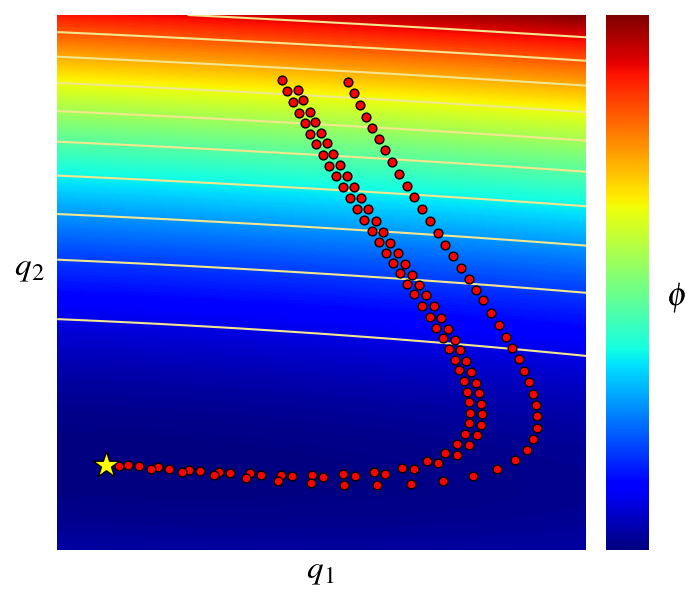

In [22]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=20)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_potential.png', format='png', dpi=300, bbox_inches="tight")

### Vector Field

In [10]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
phi = KernelDeformation(obstacle.to(device), weights = 10.0*torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
# embedding.local_deformation = phi


field = model(torch.cat((grid_x,grid_v),dim=1))
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

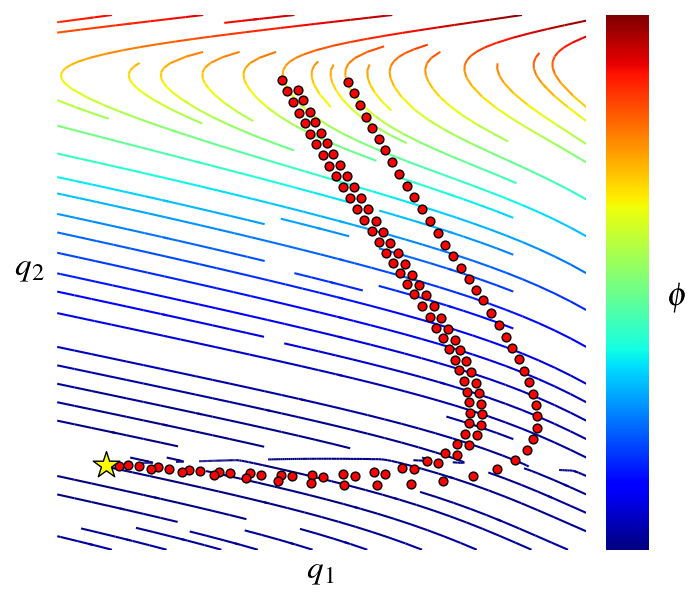

In [11]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=20)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_field.png', format='png', dpi=300, bbox_inches="tight") 

### Streamlines

In [12]:
# x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), length=0.01, samples=3).to(device).requires_grad_(True)
x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), la=0.1, lb=0.01, samples=5).to(device).requires_grad_(True)
v0 = torch.zeros_like(x0).to(device).requires_grad_(True)
streamlines = Integrator.second_order(dynamics=model,x0=torch.cat((x0,v0),dim=1),T=10.0, dt=0.01).cpu().detach().numpy()

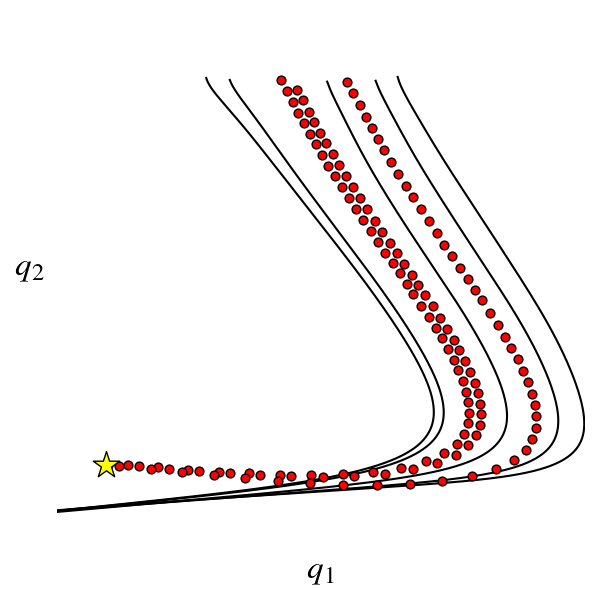

In [13]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=1.5)

ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel(r'$q_1$', fontsize=24)
ax.set_ylabel(r'$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_streamlines.png', format='png', dpi=300, bbox_inches="tight")

### Embedding

In [14]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()

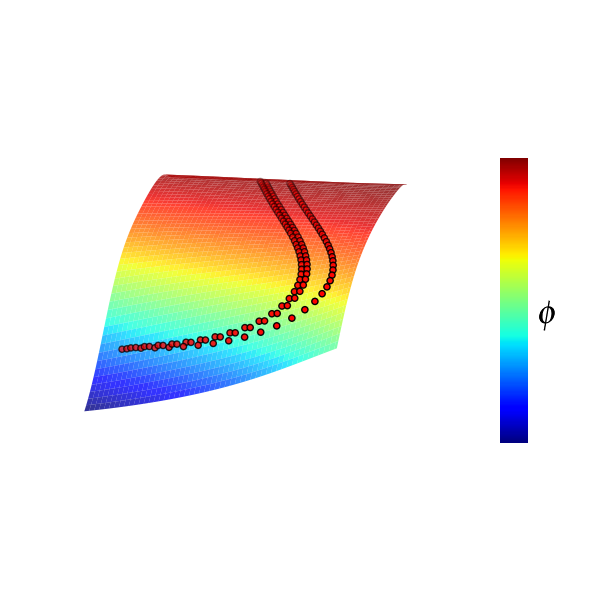

In [15]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

steps = 20
im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8)
ax.scatter(train_embedding[::steps, 0], train_embedding[::steps, 1], train_embedding[::steps, 2], s=20, edgecolors='k', c='red', zorder=10)

ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')

# Adjust plot limits, if necessary
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

ax.axis('off')

ax.view_init(elev=16, azim=-72)  # Adjust the elevation (up/down) and azimuth (left/right) an

# Add colorbar without ticks and labels
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

cbar.ax.set_yticklabels([])
cbar.ax.tick_params(length=0)
cbar.outline.set_visible(False)  # Remove colorbar frame

# Shrink colorbar to dimensions of the plot
cbar.ax.set_position([0.52, 0.1, 0.03, 0.8])  # Adjust colorbar position and width

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_embedding.png', format='png', dpi=300, bbox_inches="tight")

### Metric

In [16]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)
evals /= torch.tensor([100,100]).to(device)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

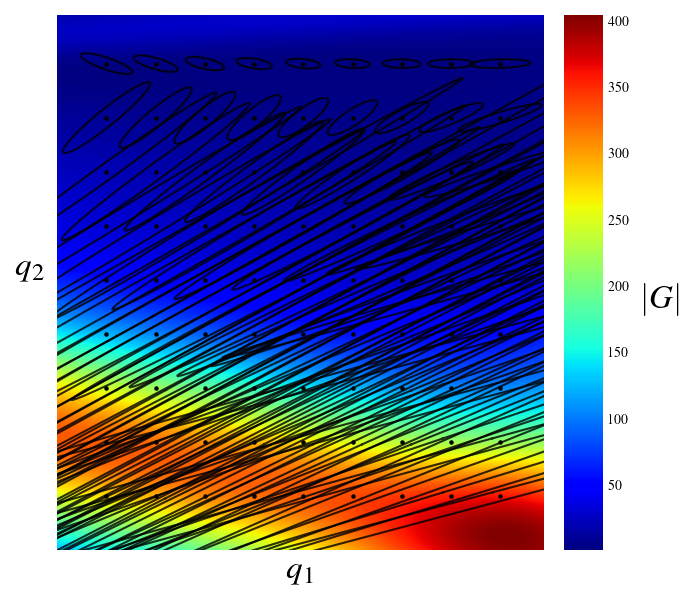

In [17]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the filled contour
contour = ax.contourf(x, y, det_metric, 500, cmap="jet")

# Plot scattered points
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)

# Plot ellipses
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
# cbar.set_ticks([])
cbar.set_label(r'$|G|$', fontsize=24, rotation=0, labelpad=25)

# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_detmetric.png', format='png', dpi=300, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [18]:
eval_scale = 10
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_evals/= torch.tensor([100,100]).to(device)

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

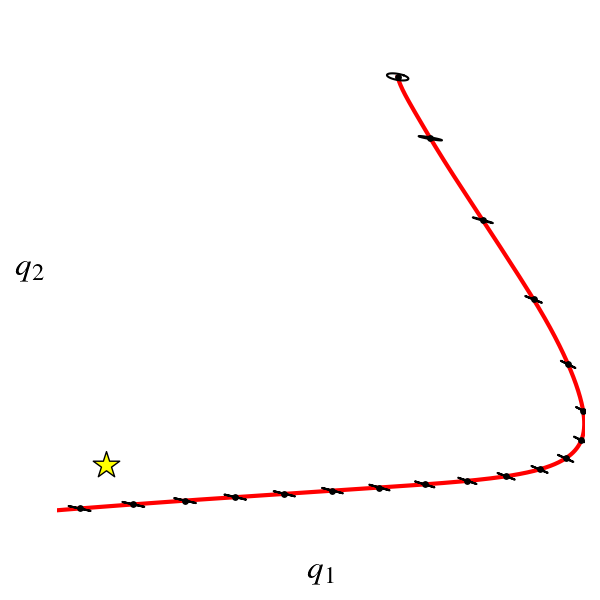

In [19]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_metric.png', format='png', dpi=300, bbox_inches="tight")

### Christoffel Symbols Ellispses on Streamlines

In [20]:
christoffel_sampled = embedding.christoffel(x_sampled, metric_sampled)
christoffel_sampled = torch.einsum('bqij,bi->bqj', christoffel_sampled, v_sampled)
christoffel_evals,christoffel_evecs = torch.linalg.eig(christoffel_sampled)
christoffel_evals = torch.real(christoffel_evals)
christoffel_evecs = torch.real(christoffel_evecs)
christoffel_evals/= torch.tensor([20,0.000001]).to(device)

christoffel_ellipses = torch.stack((christoffel_evals[:, 0].unsqueeze(-1)*theta.cos(), christoffel_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
christoffel_ellipses = torch.bmm(christoffel_evecs, christoffel_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

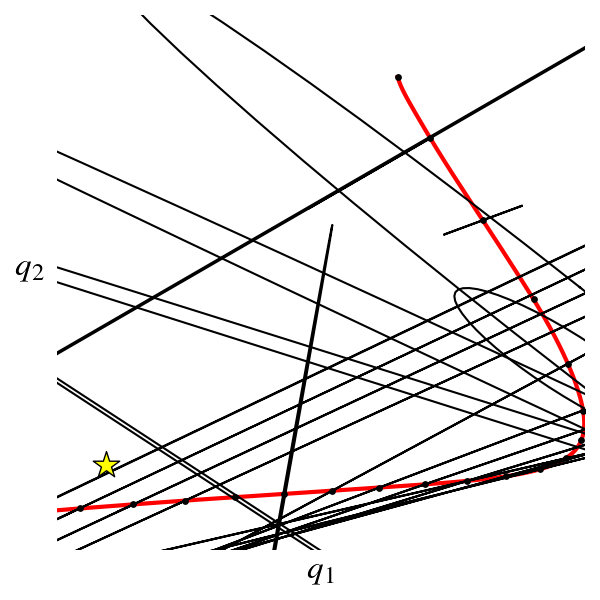

In [21]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0,christoffel_ellipses.shape[0],step):
    ax.plot(x_sampled[i, 0].detach().cpu() + christoffel_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + christoffel_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

if hasattr(embedding, 'local_deformation'):
    for i in range(obstacle.shape[0]):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
        
# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_christoffel.png', format='png', dpi=300, bbox_inches="tight")